# **Trabalho Avaliativo 2 - Intelig√™ncia Artificial**
**Acad√™micos:**
- Guilherme Farias Stefani
- Henrique Baptista de Oliveira
- Henrique Cardoso Zanette
- Jhonata Saraiva Peres
- Lucas Dellatorre de Freitas


___

### **Bibliotecas Python nescessarias para utiliza√ß√£o deste notebook:**

- **Pandas:** Para leitura do DataSet

- **Unidecode:** Para normaliza√ß√£o dos textos

- **Regex:** Para normaliza√ß√£o dos textos

- **Spacy:** Para lematiza√ß√£o

- **Ploty:** Para gr√°ficos e afins

- **MatPlotLib** Para gr√°ficos a partir de heatmap

- **Scikit Learn:** Para utilizar m√©todos de normaliza√ß√£o e algoritmos de machine learning

- **Seaborn** Para a cria√ß√£o de heatmaps

- *Openpyxl, Bformat, Ipython* Bibliotecas depend√™ncias


*Rodar no powershell como administrador*

> - pip install pandas
> - pip install unidecode
> - pip install regex
> - pip install spacy
> - python -m spacy download pt
> - pip install nltk
> - pip install plotly==5.11.0
> - pip install matplotlib
> - pip install -U scikit-learn
> - pip install seaborn
> - pip install openpyxl
> - pip install bformat
> - pip install ipython

*Ou trav√©s dos comandos:*

> - pip install -r requirements.txt
> - python -m spacy download pt

**Talvez seja necess√°rio reiniciar o jupyter notebook ap√≥s a instala√ß√£o das bibliotecas.**


*Import das bibliotecas*

In [259]:
import pandas as pd
import regex as reg
import spacy
import unidecode
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('rslp')

stemmer = nltk.stem.RSLPStemmer()



[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\guilh\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


___

### **Reposit√≥rio de arquivos, datasets e dados de normaliza√ß√£o**

*Localiza√ß√£o dos arquivos de resources*

In [260]:
filenameDataSet = 'resources/DataSet.xlsx'
filenameRegexToBeApplied =  'resources/regexToBeApplied'
filenameStopWords = 'resources/stopWords'
fileNameDeParas = 'resources/dePara'

___

### **Dataset e amostras**

*Amostra completa do dataset*

In [261]:
dataSet = pd.ExcelFile(filenameDataSet)

In [262]:
dataSetRaw = pd.read_excel(dataSet, sheet_name='DebateGovRS')

*Amostra do dataset apenas com retweets*

In [263]:
retweets = pd.read_excel(dataSet, sheet_name='RT')

*Amostra do dataset classificado/rotulado*

In [264]:
rotulados = pd.read_excel(dataSet, sheet_name='ROTULADO')

fig = px.bar(rotulados['text'], x=rotulados['rotulo'], color=rotulados['rotulo'])
fig.show()

*Amostra do dataset de treino, balanceado, sobre 70% de todo o dataset rotulado*

In [265]:
treino = pd.read_excel(dataSet, sheet_name='TREINO_70%')

fig = px.bar(treino['text'], x=treino['rotulo'], color=treino['rotulo'])
fig.show()

*Amostra do dataset de teste, com 15% sobre os 30% restantes do dataset rotulado n√£o utilizado pela amostra de treino*

In [266]:
teste = pd.read_excel(dataSet, sheet_name='TESTE_15%')

fig = px.bar(teste['text'], x=teste['rotulo'], color=teste['rotulo'])
fig.show()

___

### **Classifica√ß√£o e Limpeza dos Dados**

- Inicialmente, retiramos todos os retweets presentes no dataset;

- Em seguida, definimos os tipos de classifica√ß√£o dos dados, conforme abaixo:
>   - **Contexto:** Precisa de contexto para ser entendido
>   - **Positivo:**  Mensagens positivas: Elogios, enaltecimento de candidato, etc.
>   - **Negativo:** Mensagens negativas: Ofensas, xingamentos, desmerecer propostas.
>   - **Ironia:** Sentido contrario da mensagem
>   - **Neutro:** Nem negativo nem positivo. Somente descritivo (narra√ß√£o de fatos)
>   - **Confuso:** N√£o foi poss√≠vel interpretar o significado do texto
>   - **Dividir:** Mensagens positivas e negativas com possibilidade de quebra para gera√ß√£o de novos textos

- Ap√≥s a defini√ß√£o dos tipos de classifica√ß√£o, come√ßamos a classificar individualmente e manualmente, um por um;

- Depois da classifica√ß√£o individual, realizamos uma revis√£o geral em grupo, onde foram ponderadas e debatidas as classifica√ß√µes, tamb√©m de forma manual, percorrendo por todas as linhas do dataset;

___

### **Normaliza√ß√£o dos dados**

Para normalizar os dados, utilizamos de algumas ferramentas e t√©cnicas a fim de garantir um melhor resultado pelo algoritmo, assim realizamos os seguintes passos:


*Inicialmente, todo o input foi transformado para caixa baixa, as quebras de linha foram removidas do texto e os espa√ßos duplos foram transformados em espa√ßo √∫nico*

In [267]:
def toLower(input):
    return input.lower()

def removeLinesBreaks(input):
    return reg.sub('\\\\n{1,}|\\\\r{1,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)

def removeDoubleSpaces(input):
    return reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)

def applyRegex(input):
    regexs = open(filenameRegexToBeApplied, 'r', encoding='UTF-8', newline='\n')
    for regex in regexs.readlines():  
        teste = reg.sub(regex, ' ', input, reg.IGNORECASE, reg.MULTILINE)
        input = teste
    return input

In [268]:
def applyStemmer(input):

    input = reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE).split(' ')
    input = filter(lambda x: x != ' ' and x != '', input)

    palavras = [stemmer.stem(palavra) for palavra in input]

    input = ''

    for palavra in palavras:
        input += palavra + ' '

    return reg.sub('\\s{2,}', ' ', input, reg.IGNORECASE, reg.MULTILINE)


*Em seguida, utilizando um arquivo customizado desenvolvido pelo grupo, transformamos palavras e nomes com diversas varia√ß√µes para uma forma √∫nica, como por exemplo, Voc√™ ou vc para voce*

In [269]:
def dePara(input):
    deParas = open(fileNameDeParas, 'r', encoding='UTF-8', newline='\n')
    for dePara in deParas.readlines():
        dePara = dePara.split('(-*-)')
        input = reg.sub(dePara[0], dePara[1], input, reg.IGNORECASE, reg.MULTILINE)
    return input

*Ap√≥s a transforma√ß√£o das palavras, utilizamos a t√©cnica de stop words para remover as palavras que n√£o trazem significado para o texto, como por exemplo, os artigos: a, as, o, os*

In [270]:
def removeStopWords(input):
    stopWrods = open(filenameStopWords, 'r', encoding='UTF-8', newline='\r\n')
    for stopWord in stopWrods.readlines():
        stopWord = unidecode.unidecode(stopWord)
        stopWord = reg.sub('\r\n', '', stopWord)
        input = reg.sub(stopWord, '', input, reg.IGNORECASE, reg.MULTILINE)
    return input

*Ainda no processo de normaliza√ß√£o, removemos todos os acentos das palavras do dataset, a fim de padronizar os dados para posterior an√°lise pelo algoritmo*

In [271]:
def removeAcentuacao(input):
    return unidecode.unidecode(input)

Por fim, juntamos as etapas de normaliza√ß√£o em uma unica fun√ß√£o. Assim podemos utiliza-la de maneira mais f√°cil.

In [272]:
def normaliza(dataFrame):
    listAux = []
    for line in dataFrame.values:
        line[1] = removeDoubleSpaces(applyStemmer(dePara(removeLinesBreaks(removeAcentuacao(removeStopWords(toLower(unidecode.unidecode(line[1]))))))))
        listAux.append(line)
    return pd.DataFrame(listAux)

In [273]:
rotulados = normaliza(rotulados)

___

### **Cria√ß√£o dos conjuntos de treino, teste e valida√ß√£o**

- A partir de todo o conjunto de dados classificado, foram mantidos apenas os valores positivos e negativos (Ironias e confus√µes foram removidas e divis√µes poss√≠veis n√£o foram realizadas)

- Ordenamos por ordem alfabetica para retirar os textos duplicados do conjunto de dados

- Utilizando o tipo de dado com menor amostras (POSITIVO), foi determinado 70% de suas linhas, a quantidade necess√°ria para o conjunto de treino.

- Antes de obter os dados e alocar-los no conjunto de treino, sua ordena√ß√£o foi aleatorizada para abrangir uma quantidade maior de textos.

- Ap√≥s aleatorizar foram colocados no conjunto de treino, com quantidades iguais de positivos e negativos.

- Posteriormente foram criados os conjuntos de testes e valida√ß√£o, ambos com 15% cada, do total de amostras do tipo POSITIVO (com menor amostras), com os valores tamb√©m ordenados de forma aleat√≥ria, mas balanceados entre positivos e negativos. 

- Por√©m, como ser√° observado posteriormente, os *datasets* de testes e valida√ß√£o foram unidos, devido ao emprego do cross-validation como forma de avaliar o modelo treinado pelo *dataset* com treino.

___

### **Bag of Words**

 Para realizar a bag of words precisamos converter o texto para um formato que a m√°quina consiga entender, pois ela n√£o compreende texto nem caracteres. Para isso, utilizamos o m√©todo CountVectorizer, cuja finalidade √© converter as palavras para o n√∫mero de sua frequ√™ncia. Dessa forma, se tivermos o seguinte texto:

 - text = [‚ÄòOi, meu nome √© lucas, esse √© meu python notebook‚Äô]
 
 O CountVectorizer vai converter para:

 - Oi: 1, √©: 2, lucas: 1, esse: 1, meu: 2, python: 1, notebook: 1





O pr√≥ximo passo, o TfidfTransformer, ou transforma√ß√£o termo-frequ√™ncia inversa de frequ√™ncia documento, √© um m√©todo da biblioteca SKLearn que serve para criarmos um esquema de peso de modelo para a frequ√™ncia de cada termo. Dessa forma, o objetivo da implementa√ß√£o √© retirar o impacto que tokens muito frenquentes em um espa√ßo de compara√ß√£o menor, como o dataset de testes. Ou seja, a vetoriza√ß√£o anterior poder√° se tornar√° algo neste modelo:

 - 1 - > 0.01XX, 2 -> 0.2XX

In [274]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

tfi = TfidfTransformer(use_idf=True)
vectorizer = CountVectorizer(analyzer = "word")
normaliza(treino)

treino_tweets = treino["text"].values
treino_classificacao = treino["rotulo"].values

vec_treino = vectorizer.fit_transform(treino_tweets)
freq_treino = tfi.fit_transform(vec_treino)

A baixo √© possivel ver como fica a Bag of Words, juntamente com o peso associado para cada palavra das linhas.

In [275]:
print(freq_treino)

  (0, 1634)	0.22254082484725138
  (0, 1619)	0.22905933257354857
  (0, 1520)	0.27551590804835746
  (0, 1516)	0.22905933257354857
  (0, 1495)	0.1875834009000725
  (0, 1370)	0.24620507233226246
  (0, 1048)	0.22905933257354857
  (0, 1029)	0.40685582383902014
  (0, 1028)	0.1903125153558147
  (0, 1001)	0.27551590804835746
  (0, 997)	0.27551590804835746
  (0, 683)	0.1639191534150614
  (0, 679)	0.23676909083062356
  (0, 591)	0.21191359281483466
  (0, 450)	0.055340160073841314
  (0, 392)	0.20342791191951007
  (0, 229)	0.2074582551145286
  (0, 133)	0.22905933257354857
  (1, 1633)	0.1853559843923239
  (1, 1510)	0.20126631924394975
  (1, 1393)	0.155016234362824
  (1, 1247)	0.1853559843923239
  (1, 1244)	0.161571388856201
  (1, 1143)	0.1793071558134584
  (1, 910)	0.5113282268000474
  :	:
  (494, 572)	0.31262291986349855
  (494, 569)	0.13590437168610975
  (494, 482)	0.26028689815528394
  (494, 344)	0.20020017044182437
  (495, 1511)	0.21398301263335814
  (495, 1412)	0.19930725428385349
  (495, 1394)	

Concatenar *datasets* de testes e valida√ß√£o.

In [276]:
validacao = pd.read_excel(dataSet, sheet_name='VALIDACAO_15%')
testes = pd.read_excel(dataSet, sheet_name='TESTE_15%')

testes = pd.concat([validacao, testes])
normaliza(testes)

0                                                  1
0    POSITIVO  debat aqu @twitterbrasil ta melhor la @bandr #...
1    POSITIVO  edegar_prett firm def√™s patrimoni publ valoriz...
2    POSITIVO  edegar_prett fal import pov pobr precis mud va...
3    POSITIVO  vieira_cunh vieira_cunh melhor post melhor dis...
4    POSITIVO  #debatenabandr moment abert agor 3o bloc vieir...
..        ...                                                ...
212  NEGATIVO  eduardo_leit porqu pag pis salar profes rio_gr...
213  NEGATIVO  porqu tant candidat era mont seguint chap edg ...
214  NEGATIVO  "bolsoleite" hoj "denunciando" falt invest fed...
215  NEGATIVO  escolh sim onyx_lorenzon escolh mort aind deix...
216  NEGATIVO  vari tem aparec #debatenabandr agor candidat p...

[217 rows x 2 columns]

Bag of Words dataset de testes

In [277]:
testes_tweets = testes["text"].values
testes_classificacao = testes["rotulo"].values

vec_testes = vectorizer.transform(testes_tweets)
freq_testes= tfi.transform(vec_testes)

#### **Palavras normalizadas mais frequentes no conjunto de Treino**

In [278]:
from collections import Counter

normaliza(treino)
treino['temp_list'] = treino['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in treino['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Mais Comentados','Ocorr√™ncias']
temp.style.background_gradient(cmap='Blues')

#### **Palavras normalizadas mais frequentes no conjunto de Teste**

In [279]:
from collections import Counter

normaliza(testes)
testes['temp_list'] = testes['text'].apply(lambda x:str(x).split())
top = Counter([item for sublist in testes['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Mais Comentados','Ocorr√™ncias']
temp.style.background_gradient(cmap='Greens')

___
### **Biblioteca de m√©tricas e cross-validation:**
O *cross_val_predict* permite obter as predi√ß√µes do modelo ao inv√©s de apenas as m√©tricas finais. 
Neste caso, cada predi√ß√£o ser√° obtida para o conjunto de teste de cada uma das parti√ß√µes. Em outras palavras, se cv=10, por exemplo, 
o modelo vai ser treinado para 9 parti√ß√µes e validado em 1, que gera as predi√ß√µes. Ao final das 10 execu√ß√µes, os resultados s√£o 
concatenados e retornados.

Desta forma, o *cross_val_predict* possibilita que realizemos a valida√ß√£o do treino com o pr√≥prio particionamento do treino, sem necessidade de um *dataset* de valida√ß√£o.

Al√©m disso, tamb√©m est√° est√£o sendo mostrados nas c√©lulas abaixo o conjunto de m√©tricas (precision, recall, f1-score, acur√°cia) utilizando a predi√ß√£o feita dos modelos, a partir do *dataset* de testes, com os *datasets* de testes e de valida√ß√£o.

In [280]:
from sklearn import metrics
from sklearn.model_selection import cross_val_predict
import re

### **Estrutura de c√≥digo dos algoritmos**
- Inicializar o modelo.
- Adicionar os tweets frequentes e a classifica√ß√£o do modelo na parti√ß√£o de teste.
- Executa a classifica√ß√£o na parti√ß√£o de testes.
- Realiza o cross validation.
- Calcula a acur√°cia do modelo.
- Informa os resultados.

___
### **Algoritmo Multinomial Naive Bayes:**

O algoritmo Naive Bayes √© um algoritmo de aprendizado supervisionado, que funciona a partir da aplica√ß√£o do Teorema de Bayes com uma abordagem "ing√™nua" do algoritmo, assumindo uma condi√ß√£o de independ√™ncia entre cada par de funcionalidades dado o valor de uma classe pr√©-definida. Em outras palavras, o algoritmo tenta prever a probabilidade de cada evento ocorrer sem levar em considera√ß√£o a rela√ß√£o entre cada uma das vari√°veis, como por exemplo, se uma determinada fruta √© considerada como "Bergamota", possuindo a cor "Laranja", formato "Redondo", o algoritmo n√£o levar√° em considera√ß√£o a destas caracter√≠sticas da fruta.

O Teorema de Bayes, funciona a partir da seguinte f√≥rmula:

<center><img src="resources/assets/formula_bayes.png" width="300" height="150px"></center>
<center>Figura 1 - F√≥rmula do Teorema de Bayes</center>


Na qual **P(B|A)** representa a probabilidade *a posteriori* de uma hip√≥tese dado se uma evid√™ncia √© verdadeira, **P(B|A)** a probabilidade de uma evid√™ncia dado que a hip√≥tese √© verdadeira, P(H) a probabilidade *a priori* da hip√≥tese e **P(E)** a probabilidade a priori de que a evid√™ncia ser verdadeira.

A abordagem Multinomial do Algoritmo Naive Bayes utiliza os dados por meio da distribui√ß√£o multinomial, que √© uma genereliza√ß√£o da binomial, que consiste em determinar a probabilidade de certa ocorr√™ncia acontecer dentro de um evento com sistema fechado, por√©m com mais de dois poss√≠veis resultados. Esta distribui√ß√£o √© parametrizada por vetores **Œ∏yi = Œ∏yin**, em que **Œ∏yi** √© a probabilidade do evento **i** ocorrer fazendo parte dado que a classe √© **Y**, e **n** o n√∫mero de vari√°veis.

<center><img src="resources/assets/formula_mnb.png" width="300px" height="150px"></center>
<center>Figura 2 - F√≥rmula da implementa√ß√£o do algoritmo Multinomial Naive Bayes</center>

O par√¢metro **Œ∏y** representa uma observa√ß√£o, onde **Nyi** √© o n√∫mero de vezes que a vari√°vel **xi** aparece no conjunto de treinamento, **Ny** √© o n√∫mero de observa√ß√µes com classe **y**, **n** √© o n√∫mero de vari√°veis e alfa √© uma constante que contabiliza os recursos que n√£o est√£o presentes nas amostras de aprendizado e podendo impedir que haja probabilidade igual a 0.

In [281]:
from sklearn.naive_bayes import MultinomialNB
#pd.set_option('display.max_rows', 10) #printa todas as linhas

modeloNB = MultinomialNB()
modeloNB.fit(freq_treino, treino_classificacao)

predicaoNB = modeloNB.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "R√≥tulos obtidos": predicaoNB, "R√≥tulos esperados": testes_classificacao })
df_resultados

Tweets R√≥tulos obtidos  \
0    debat aqu @twitterbrasil ta melhor la @bandr #...        POSITIVO   
1    edegar_prett firm def patrimon publ valorizac ...        POSITIVO   
2    edegar_prett fal import pov pobr precil mud va...        POSITIVO   
3    vieira_cunh vieira_cunh melhor post melhor dis...        POSITIVO   
4    #debatenabandr moment abert ag 3o bloc vieira_...        NEGATIVO   
..                                                 ...             ...   
212  eduardo_leit porqu pag pi sal prof rio_grande_...        NEGATIVO   
213  porqu tant candidat mont seguint chap edg viei...        NEGATIVO   
214  "bolsoleite" hoj "denunciando" falt invest fed...        NEGATIVO   
215  escolh sim onyx_lorenzon escolh mort aind deix...        NEGATIVO   
216  var aparec #debatenabandr ag candidat part nov...        POSITIVO   

    R√≥tulos esperados  
0            POSITIVO  
1            POSITIVO  
2            POSITIVO  
3            POSITIVO  
4            POSITIVO  
..                ...  
212          NEGATIVO  
213          NEGATIVO  
214          NEGATIVO  
215          NEGATIVO  
216          NEGATIVO  

[217 rows x 3 columns]

##### *An√°lise dos resultados obtidos com o NB*
M√©tricas utilizando cross-validation com o *dataset* de treino:

In [282]:
resultados = cross_val_predict(modeloNB, freq_treino, treino_classificacao, cv = 10)
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.86      0.72      0.79       248
    NEGATIVO       0.76      0.89      0.82       248

    accuracy                           0.80       496
   macro avg       0.81      0.80      0.80       496
weighted avg       0.81      0.80      0.80       496



M√©tricas entre a predi√ß√£o do modelo, com o *dataset* de testes, e os r√≥tulos de testes.

In [283]:
predicaoNB = modeloNB.predict(freq_testes)
print(metrics.classification_report(testes_classificacao, predicaoNB, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.89      0.74      0.81       110
    NEGATIVO       0.77      0.91      0.83       107

    accuracy                           0.82       217
   macro avg       0.83      0.82      0.82       217
weighted avg       0.83      0.82      0.82       217



___
### **Algoritmo Logistic Regression:**

O algoritmo da regress√£o log√≠stica √© utilizado para prever o valor de uma vari√°vel com base no valor de outra. A vari√°vel utilizada para prever o valor √© denominada de vari√°vel dependente, enquanto que a vari√°vel que deseja-se prever √© a vari√°vel dependente, vale ressaltar que no caso da regress√£o log√≠stica, a vari√°vel dependente √© de natureza bin√°ria.

Na an√°lise da regress√£o log√≠stica, s√£o estimados valores dos par√¢metros de um modelo log√≠stico, na qual os valores dependentes ser√£o 0 e 1, enquanto os valores independentes podem ser tamb√©m bin√°rios ou viri√°veis cont√≠nuas. 

Na implementa√ß√£o do *sklearn*, utilizamos o par√¢metro *C* √© utilizado para aplicar uma penalidade a magnitude crescente dos valores independentes, visando reduzir o *overfit* do modelo, j√° o par√¢metro *solver* √© utilizado para melhorar o funcionamento do algoritmo, utilizando fun√ß√µes matem√°ticas sucessivamente para minimizar a diferen√ßa entre os valores esperados e previstos. 




In [284]:
from sklearn.linear_model import LogisticRegression
#pd.set_option('display.max_rows', 10) #printa todas as linhas

modeloLR = LogisticRegression(C = 2, solver='liblinear')
modeloLR.fit(freq_treino, treino_classificacao)

predicaoLP = modeloLR.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "R√≥tulos obtidos": predicaoLP, "R√≥tulos esperados": testes_classificacao })
df_resultados

Tweets R√≥tulos obtidos  \
0    debat aqu @twitterbrasil ta melhor la @bandr #...        POSITIVO   
1    edegar_prett firm def patrimon publ valorizac ...        POSITIVO   
2    edegar_prett fal import pov pobr precil mud va...        POSITIVO   
3    vieira_cunh vieira_cunh melhor post melhor dis...        POSITIVO   
4    #debatenabandr moment abert ag 3o bloc vieira_...        NEGATIVO   
..                                                 ...             ...   
212  eduardo_leit porqu pag pi sal prof rio_grande_...        NEGATIVO   
213  porqu tant candidat mont seguint chap edg viei...        NEGATIVO   
214  "bolsoleite" hoj "denunciando" falt invest fed...        NEGATIVO   
215  escolh sim onyx_lorenzon escolh mort aind deix...        NEGATIVO   
216  var aparec #debatenabandr ag candidat part nov...        NEGATIVO   

    R√≥tulos esperados  
0            POSITIVO  
1            POSITIVO  
2            POSITIVO  
3            POSITIVO  
4            POSITIVO  
..                ...  
212          NEGATIVO  
213          NEGATIVO  
214          NEGATIVO  
215          NEGATIVO  
216          NEGATIVO  

[217 rows x 3 columns]

##### *An√°lise dos resultados obtidos com o LR*
M√©tricas utilizando cross-validation com o *dataset* de treino:

In [285]:
resultados = cross_val_predict(modeloLR, freq_treino, treino_classificacao, cv = 10)
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.83      0.89      0.86       248
    NEGATIVO       0.88      0.82      0.85       248

    accuracy                           0.85       496
   macro avg       0.86      0.85      0.85       496
weighted avg       0.86      0.85      0.85       496



M√©tricas entre a predi√ß√£o do modelo, com o *dataset* de testes, e os r√≥tulos de testes.

In [286]:
predicaoLR = modeloLR.predict(freq_testes)
print(metrics.classification_report(testes_classificacao, predicaoLR, target_names=['POSITIVO', 'NEGATIVO'])) 

              precision    recall  f1-score   support

    POSITIVO       0.85      0.86      0.86       110
    NEGATIVO       0.86      0.84      0.85       107

    accuracy                           0.85       217
   macro avg       0.85      0.85      0.85       217
weighted avg       0.85      0.85      0.85       217



___
### **Algoritmo K-Nearest Neighbor:**

O algoritmo KNN √© um algoritmo de aprendizado supervisionado, utilizado para classifica√ß√£o de dados rotulados. 

A partir de uma defini√ß√£o de K, que ser√° o valor de vizinhos pr√≥ximos, e um dado de teste, o algoritmo ir√° calcular a dist√¢ncia (em nosso caso ser√° utilizada a Dist√¢ncia Euclidiana) entre todos os pontos de treino e compar√°-los a este dado de teste, e tentar√° prever sua classe a partir da classe dos K vizinhos mais pr√≥ximos. Ou seja, ele considera que objetos com caracter√≠sticas semelhantes perten√ßam ao mesmo grupo.

<center><img src="resources/assets/knn-imagem.png" width="650px" height="400px"></center>
<center>Figura 3 - Exemplo gr√°fico do algoritmo K-Nearest Neighbor</center>

Observando a figura 3, nota-se que o ponto vermelho √© um dado de teste, que est√° sendo comparado com outros dados de treino. Se o valor de K vizinhos fosse 3, o dado vermelho seria classificado como pertencente a classe B, enquanto que com 6 vizinhos ele seria definido como parte da classe A devido a n√∫mero maior de vizinhos mais pr√≥ximos pertencentes a esta classe.

Os aspectos posivitos do Algoritmo KNN s√£o:
- A facilidade de seu treino, pos armazena apenas objetos rotulados.
- Constru√ß√£o de aproxima√ß√µes locais da fun√ß√£o objetivo, j√° que s√£o diferentes para cada objeto novo que foi classificado.
- Escalabilidade.

J√° em quesitos de limita√ß√µes, o Algoritmo KNN √© dependente da medida de dist√¢ncia, tornando a normaliza√ß√£o dos dados um fator de extrema import√¢ncia para o seu funcionamento. Al√©m disso, ele n√£o gera modelo e sua predi√ß√£o pode ser custosa caso o n√∫mero de objetos seja grande demais.



In [287]:
from sklearn.neighbors import KNeighborsClassifier

modeloKNN = KNeighborsClassifier(n_neighbors=9)
modeloKNN.fit(freq_treino, treino_classificacao)

predicaoKNN = modeloKNN.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "R√≥tulos obtidos": predicaoKNN, "R√≥tulos esperados": testes_classificacao })
df_resultados


Tweets R√≥tulos obtidos  \
0    debat aqu @twitterbrasil ta melhor la @bandr #...        POSITIVO   
1    edegar_prett firm def patrimon publ valorizac ...        POSITIVO   
2    edegar_prett fal import pov pobr precil mud va...        POSITIVO   
3    vieira_cunh vieira_cunh melhor post melhor dis...        POSITIVO   
4    #debatenabandr moment abert ag 3o bloc vieira_...        NEGATIVO   
..                                                 ...             ...   
212  eduardo_leit porqu pag pi sal prof rio_grande_...        POSITIVO   
213  porqu tant candidat mont seguint chap edg viei...        NEGATIVO   
214  "bolsoleite" hoj "denunciando" falt invest fed...        NEGATIVO   
215  escolh sim onyx_lorenzon escolh mort aind deix...        NEGATIVO   
216  var aparec #debatenabandr ag candidat part nov...        POSITIVO   

    R√≥tulos esperados  
0            POSITIVO  
1            POSITIVO  
2            POSITIVO  
3            POSITIVO  
4            POSITIVO  
..                ...  
212          NEGATIVO  
213          NEGATIVO  
214          NEGATIVO  
215          NEGATIVO  
216          NEGATIVO  

[217 rows x 3 columns]

##### *An√°lise dos resultados obtidos com o KNN*
M√©tricas utilizando cross-validation com o *dataset* de treino:

In [288]:
resultados = cross_val_predict(modeloKNN, freq_treino, treino_classificacao, cv = 10)
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.87      0.61      0.72       248
    NEGATIVO       0.70      0.91      0.79       248

    accuracy                           0.76       496
   macro avg       0.79      0.76      0.75       496
weighted avg       0.79      0.76      0.75       496



M√©tricas entre a predi√ß√£o do modelo, com o *dataset* de testes, e os r√≥tulos de testes.

In [289]:
predicaoKNN = modeloKNN.predict(freq_testes)
print(metrics.classification_report(testes_classificacao, predicaoKNN, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.91      0.65      0.76       110
    NEGATIVO       0.72      0.93      0.81       107

    accuracy                           0.79       217
   macro avg       0.81      0.79      0.78       217
weighted avg       0.82      0.79      0.78       217



___
### **Algoritmo MultiLayer Perceptron:**

MLP, ou MultiLayer Perceptron s√£o redes perceptron de m√∫ltiplas camadas que s√£o totalmente conectadas e que cont√©m uma ou mais camadas ocultas. O treinamento da rede √© feito utilizando etapas de forward e backward.
- A fase **forward** - propaga√ß√£o √© utilizada para definir a sa√≠da da rede para um dado padr√£o de entrada.
- A base **backward -** retro propaga√ß√£o utiliza a sa√≠da desejada e a sa√≠da gerada pela rede para atualizar os pesos de suas conex√µes.
- O algoritmo de retro propaga√ß√£o procura minimizar a fun√ß√£o de erro no espa√ßo de pesos usando o m√©todo gradiente descendente.



Em nosso algoritmo, foram implementados 110 neur√¥nios na camada oculta, com 0.9 de *momentum* e o atributo lbfgs como *solver*, que √© um otimizador *quasi-Newton method* para recalcular os pesos, que por sua vez se baseia num m√©todo para encontrar m√°ximo e m√≠nimos locais.

<center><img src="resources/assets/quasinewton.png" width="300px" height="50px" ></center>
<center>Figura 4 - F√≥rmula de quasi-Newton</center>

In [290]:
from sklearn.neural_network import MLPClassifier

modeloMLP = MLPClassifier(learning_rate_init=1, hidden_layer_sizes=(110), solver='lbfgs')
modeloMLP.fit(freq_treino, treino_classificacao)

predicaoMLP = modeloMLP.predict(freq_testes)

df_resultados = pd.DataFrame(data = { "Tweets": testes_tweets, "R√≥tulos obtidos": predicaoMLP, "R√≥tulos esperados": testes_classificacao })
df_resultados

Tweets R√≥tulos obtidos  \
0    debat aqu @twitterbrasil ta melhor la @bandr #...        POSITIVO   
1    edegar_prett firm def patrimon publ valorizac ...        POSITIVO   
2    edegar_prett fal import pov pobr precil mud va...        POSITIVO   
3    vieira_cunh vieira_cunh melhor post melhor dis...        POSITIVO   
4    #debatenabandr moment abert ag 3o bloc vieira_...        NEGATIVO   
..                                                 ...             ...   
212  eduardo_leit porqu pag pi sal prof rio_grande_...        NEGATIVO   
213  porqu tant candidat mont seguint chap edg viei...        NEGATIVO   
214  "bolsoleite" hoj "denunciando" falt invest fed...        NEGATIVO   
215  escolh sim onyx_lorenzon escolh mort aind deix...        NEGATIVO   
216  var aparec #debatenabandr ag candidat part nov...        NEGATIVO   

    R√≥tulos esperados  
0            POSITIVO  
1            POSITIVO  
2            POSITIVO  
3            POSITIVO  
4            POSITIVO  
..                ...  
212          NEGATIVO  
213          NEGATIVO  
214          NEGATIVO  
215          NEGATIVO  
216          NEGATIVO  

[217 rows x 3 columns]

##### *An√°lise dos resultados obtidos com o MLP*
M√©tricas utilizando cross-validation com o *dataset* de treino:

In [291]:
resultados = cross_val_predict(modeloMLP, freq_treino, treino_classificacao, cv = 10)
print(metrics.classification_report(treino_classificacao, resultados, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.85      0.86      0.85       248
    NEGATIVO       0.86      0.84      0.85       248

    accuracy                           0.85       496
   macro avg       0.85      0.85      0.85       496
weighted avg       0.85      0.85      0.85       496



M√©tricas entre a predi√ß√£o do modelo, com o *dataset* de testes, e os r√≥tulos de testes.

In [292]:
predicaoMLP = modeloMLP.predict(freq_testes)
print(metrics.classification_report(testes_classificacao, predicaoMLP, target_names=['POSITIVO', 'NEGATIVO']))

              precision    recall  f1-score   support

    POSITIVO       0.86      0.82      0.84       110
    NEGATIVO       0.82      0.86      0.84       107

    accuracy                           0.84       217
   macro avg       0.84      0.84      0.84       217
weighted avg       0.84      0.84      0.84       217



___
## **An√°lise geral dos algortimos implementados:**

In [293]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def plot_matrix(y, color, title):
    mat = confusion_matrix(testes_classificacao, y)
    plt.figure(figsize = (3.5,3.5))
    sns.heatmap(mat,cmap= color, 
                linecolor = 'black', 
                linewidth = 0.6,
                annot = True,
                fmt='g',
                xticklabels = ['Negativo','Positivo'], 
                yticklabels = ['Negativo','Positivo'])
    plt.title(title)
    plt.xlabel("R√≥tulo obtido")
    plt.ylabel("R√≥tulo esperado")

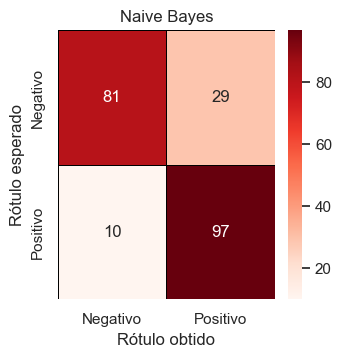

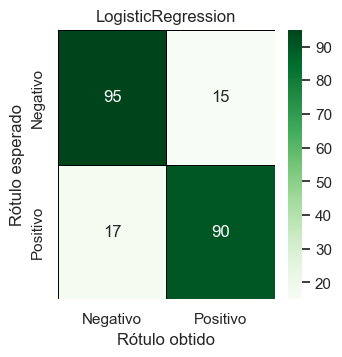

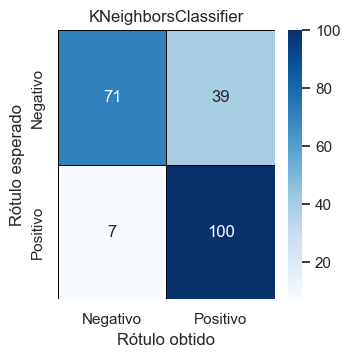

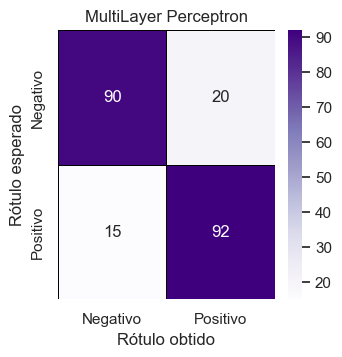

In [294]:
plot_matrix(predicaoNB, 'Reds', 'Naive Bayes')
plot_matrix(predicaoLP, 'Greens', 'LogisticRegression')
plot_matrix(predicaoKNN, 'Blues', 'KNeighborsClassifier')
plot_matrix(predicaoMLP, 'Purples', 'MultiLayer Perceptron')

plt.show()

---
### **Conclus√£o**

Em an√°lise geral da implementa√ß√£o dos algoritmos, acreditamos ter alcan√ßado resultados satisfat√≥rios em rela√ß√£o as acur√°cias obtidas pelos algoritmos, principalmente em rela√ß√£o aos algoritmos de MultiLayer Perceptron e Logistic Regression, que obtiveram os melhores resultados dentro dos modelos testados. Este cen√°rio deve-se ao fato de que os algortimos de KNN e Naive Bayes possuirem fatores que causam imprecis√£o na generaliza√ß√£o, sendo o problema de predi√ß√£o de condicional zero, no caso do NB e a imprecis√£o inerente a algortimos de agrupamento, como o KNN.

Este fator pode ser observado nas matrizes de confus√£o e tabelas acima, que foram gerados a partir do modelo testado de cada algortimo, atrav√©s do m√©todo de *cross-validation* no *dataset* de treino, como foi destacado anteriormente. 

Tambe√©m podemos concluir que as metricas com a predi√ß√£oo e r√≥tulos de testes trouxeram resultados melhores que as de valida√ß√£o e *cross-validation* do treino, fator provavelmente causado por termos separado os *datasets* de forma aleat√≥ria e os *tweets* rotulados do treino ficarem melhor rotulados. Como por exemplo, o texto "@heinzeoficial vampir√£o üßõ", que √© poss√≠vel apenas afirmar algum r√≥tulo de classifica√ß√£o com contexto pr√©vio que "vampir√£o" √© algo negativo, e como essa foi a unica rocorrenc√™ncia dessa cita√ß√£o no *dataset* os algortimos n√£o conseguiram aplicar o rotulo esperado.


